In [1]:
import datetime
from pathlib import Path

import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow import keras

In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Build a universal one hot encoder that encodes cross-dataset category and ingredients 

In [3]:
class OneHotEncoder:
    def __init__(self, all_category_list, all_ingredient_list):
        self.all_food_categories = all_category_list
        self.all_food_categories.sort()
        self.all_food_categories_integer_encoded = (
            self.__encode_categories_to_integers()
        )
        self.all_ingredients = all_ingredient_list
        self.all_ingredients.sort()
        self.all_ingredients_integer_encoded = self.__encode_ingredients_to_integers()

    def get_category_one_hot_encoding(self, category_name):
        index = self.all_food_categories_integer_encoded[category_name]
        assert index != None, f"{category_name} does not have an integer mapping"
        num_classes = len(self.all_food_categories)
        return keras.utils.to_categorical(index, num_classes)

    def get_ingredients_one_hot_encoding(self, ingredient_list):
        ingredient_list = list(
            map(lambda x: self.__transform_ingredient_to_integer(x), ingredient_list)
        )
        multi_one_hot_layer = tf.keras.layers.CategoryEncoding(
            num_tokens=len(self.all_ingredients), output_mode="multi_hot"
        )
        return multi_one_hot_layer(ingredient_list)

    def __transform_ingredient_to_integer(self, ingredient_name):
        index = self.all_ingredients_integer_encoded[ingredient_name]
        assert index != None, f"{ingredient_name} does not have an integer mapping"
        return index

    def __encode_categories_to_integers(self):
        return {
            category_name: index
            for index, category_name in enumerate(self.all_food_categories)
        }

    def __encode_ingredients_to_integers(self):
        return {
            ingredient_name: index
            for index, ingredient_name in enumerate(self.all_ingredients)
        }

## Build dataset loaders for each dataset

In [4]:
class DatasetLoader:
    def __init__(self, image_dir, metadata_dir, dataset_name):
        self.image_dir = Path(image_dir)
        self.metadata_dir = Path(metadata_dir)
        self.name = dataset_name
        self.metadata = self.load_metadata(
            self.metadata_dir / ("{dataset}_metadata.csv".format(dataset=dataset_name))
        )
        # Default : all_files = metadata, since metadata consists of records of all files
        self.all_files = self.metadata.copy()
        self.all_categories = self.extract_all_categories()
        self.all_ingredients = self.extract_all_ingredients()

    def load_image_to_arr(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        img_tensor = tf.keras.preprocessing.image.img_to_array(image)
        return tf.image.resize(img_tensor, (224, 224))

    def load_metadata(self, path):
        metadata = pd.read_csv(path, sep="\t")
        new_metadata = metadata.copy()
        new_metadata["dataset_name"] = self.name
        return new_metadata

    def extract_all_categories(self):
        return self.metadata["Category"].unique().tolist()

    def extract_all_ingredients(self):
        unique_ingredients = set()
        for ingredient_list in self.metadata["Ingredients"]:
            ingredient_list = ingredient_list.split(",")
            unique_ingredients.update(ingredient_list)
        return [*unique_ingredients]

    def extract_file_pointers(self):
        dataset_name_col = self.all_files["dataset_name"]
        index_col = self.all_files.index
        return pd.DataFrame(
            {"metadata_index": index_col, "dataset_name": dataset_name_col}
        )

    def get_tensors(self, index, one_hot_encoder):
        img_dir = self.image_dir
        row = self.all_files.loc[index]
        img_path = img_dir / row["Category"] / row["ID/File Name"]
        img_tensor = self.load_image_to_arr(img_path)
        calorie_tensor = row["Calorie(kcal)"]
        carbs_tensor = row["Carbohydrate(g)"]
        protein_tensor = row["Protein(g)"]
        fat_tensor = row["Fat(g)"]
        one_hot_category_tensor = one_hot_encoder.get_category_one_hot_encoding(
            row["Category"]
        )
        one_hot_ingredient_tensor = one_hot_encoder.get_ingredients_one_hot_encoding(
            row["Ingredients"].split(",")
        )
        return tf.constant(img_tensor), {
            "category_output": tf.constant(one_hot_category_tensor),
            "calorie_output": tf.constant(calorie_tensor),
            "carbs_output": tf.constant(carbs_tensor),
            "protein_output": tf.constant(protein_tensor),
            "fat_output": tf.constant(fat_tensor),
            "ingredients_output": one_hot_ingredient_tensor,
        }

    def flatten_tensors(self, tensor):
        result = []
        img_data = tensor[0].numpy()
        others_data = [value.numpy() for key, value in tensor[1].items()]
        result.append(img_data)
        result.extend(others_data)
        return result

    def __len__(self):
        return len(self.metadata)

In [5]:
class Recipes5k(DatasetLoader):
    def __init__(self, image_dir, metadata_dir):
        super().__init__(image_dir, metadata_dir, "recipes5k")

In [6]:
class Nutrition5k(DatasetLoader):
    def __init__(self, image_dir, metadata_dir):
        super().__init__(image_dir, metadata_dir, "nutrition5k")
        # Modify all_files since nutrition5k metadata only consists dish_level metadata not image_level
        self.all_files = pd.read_csv(self.metadata_dir / "nutrition5k_all_images.csv")

    # Override method from DatasetLoader
    def get_tensors(self, index, one_hot_encoder):
        img_dir = self.image_dir
        row = self.all_files.loc[index]
        img_path = img_dir / "generic" / row["dish_id"] / row["ID/File Name"]
        img_tensor = self.load_image_to_arr(img_path)
        dish_metadata_row = self.metadata.loc[
            self.metadata["dish_id"] == row["dish_id"]
        ].squeeze()
        calorie_tensor = dish_metadata_row["Calorie(kcal)"]
        carbs_tensor = dish_metadata_row["Carbohydrate(g)"]
        protein_tensor = dish_metadata_row["Protein(g)"]
        fat_tensor = dish_metadata_row["Fat(g)"]
        one_hot_category_tensor = one_hot_encoder.get_category_one_hot_encoding(
            dish_metadata_row["Category"]
        )
        one_hot_ingredient_tensor = one_hot_encoder.get_ingredients_one_hot_encoding(
            dish_metadata_row["Ingredients"].split(",")
        )
        return tf.constant(img_tensor), {
            "category_output": tf.constant(one_hot_category_tensor),
            "calorie_output": tf.constant(calorie_tensor),
            "carbs_output": tf.constant(carbs_tensor),
            "protein_output": tf.constant(protein_tensor),
            "fat_output": tf.constant(fat_tensor),
            "ingredients_output": one_hot_ingredient_tensor,
        }

    # Overrding the method from DatasetLoader
    def __len__(self):
        return len(self.all_files)

In [7]:
class Food101(DatasetLoader):
    def __init__(self, image_dir, metadata_dir):
        super().__init__(image_dir, metadata_dir, "food101")

## Initializing one hot encoder

In [8]:
# Get all the categories and ingredients from all datasets

# Initialize dataset loader without one-hot encoder to get all unique category and ingredients from each dataset
recipes5k = Recipes5k(
    image_dir="../Food Datasets/final-dataset/images",
    metadata_dir="../Food Datasets/final-dataset/metadata",
)
nutrition5k = Nutrition5k(
    image_dir="../Food Datasets/final-dataset/images",
    metadata_dir="../Food Datasets/final-dataset/metadata",
)
food101 = Food101(
    image_dir="../Food Datasets/final-dataset/images",
    metadata_dir="../Food Datasets/final-dataset/metadata",
)

all_categories = recipes5k.all_categories
all_categories.extend(nutrition5k.all_categories)
all_categories.extend(food101.all_categories)
all_categories = set(all_categories)

all_ingredients = recipes5k.all_ingredients
all_ingredients.extend(nutrition5k.all_ingredients)
all_ingredients.extend(food101.all_ingredients)
all_ingredients = set(all_ingredients)

In [9]:
one_hot_encoder = OneHotEncoder([*all_categories], [*all_ingredients])

## Building dataset pipeline

In [10]:
DATASETS = [recipes5k, nutrition5k, food101]
DATASETS_NAME = [x.name for x in DATASETS]


def get_dataset_cardinality(datasets):
    dataset_samples = [len(x) for x in datasets]
    return sum(dataset_samples)


def get_file_data(index, dataset_index):
    index = index.numpy()
    dataset_index = dataset_index.numpy()
    target_dataset = DATASETS[dataset_index]
    return target_dataset.flatten_tensors(
        target_dataset.get_tensors(index, one_hot_encoder)
    )


def transform_file_pointers(index, dataset_index):
    result = tf.py_function(
        get_file_data,
        [index, dataset_index],
        [
            tf.float32,
            tf.float32,
            tf.float32,
            tf.float32,
            tf.float32,
            tf.float32,
            tf.float32,
        ],
    )
    return result[0], {
        "category_output": result[1],
        "calorie_output": result[2],
        "carbs_output": result[3],
        "protein_output": result[4],
        "fat_output": result[5],
        "ingredients_output": result[6],
    }


def build_data_pipeline(datasets, sample_size=None, training_split=0.7, batch_size=32):
    if sample_size is None:
        sample_size = [1.0] * len(datasets)
    assert len(sample_size) == len(
        datasets
    ), "Illegal array of sample sizes provided. Number of sample size does not match number of datasets"
    file_pointers = [
        x.extract_file_pointers().sample(frac=s) for x, s in zip(datasets, sample_size)
    ]
    all_file_pointers = pd.concat(file_pointers)
    print(f"Total samples : {len(all_file_pointers)}")
    all_file_pointers["dataset_name"] = all_file_pointers["dataset_name"].apply(
        lambda x: DATASETS_NAME.index(x)
    )
    final_dataset = tf.data.Dataset.from_tensor_slices(
        (
            all_file_pointers["metadata_index"].tolist(),
            all_file_pointers["dataset_name"].tolist(),
        )
    )
    final_dataset = final_dataset.shuffle(len(all_file_pointers))
    training_size = int(len(all_file_pointers) * training_split)
    training_dataset = (
        final_dataset.take(training_size)
        .map(
            lambda index, name: transform_file_pointers(index, name),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache(filename="./dataset_cache/train")
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    validation_dataset = (
        final_dataset.skip(training_size)
        .map(
            lambda index, name: transform_file_pointers(index, name),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache(filename="./dataset_cache/validation")
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    print(f"Training size : {training_size}")
    print(f"Validation size : {len(all_file_pointers)-training_size}")
    return training_dataset, validation_dataset

In [11]:
training_dataset, validation_dataset = build_data_pipeline(
    [recipes5k, food101], [1.0, 0.5]
)

Total samples : 55326
Training size : 38728
Validation size : 16598


In [14]:
list(training_dataset.take(3))

[(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
  array([[[[1.99341827e+02, 1.54341827e+02, 1.23341843e+02],
           [2.03780624e+02, 1.56831635e+02, 1.26806122e+02],
           [2.06051025e+02, 1.59637756e+02, 1.26775513e+02],
           ...,
           [1.99337101e+01, 8.36223698e+00, 8.14797306e+00],
           [2.18316669e+01, 7.76022577e+00, 4.61734247e+00],
           [2.90000706e+01, 1.10000696e+01, 7.00006962e+00]],
  
          [[2.01163269e+02, 1.54163269e+02, 1.24163261e+02],
           [2.01158157e+02, 1.52433670e+02, 1.20709183e+02],
           [2.00443878e+02, 1.51443878e+02, 1.19443878e+02],
           ...,
           [2.27143078e+01, 1.19285717e+01, 1.01428356e+01],
           [2.50714550e+01, 1.10000134e+01, 7.85713005e+00],
           [3.05205421e+01, 1.43112621e+01, 9.71435547e+00]],
  
          [[1.95423477e+02, 1.46423477e+02, 1.14984695e+02],
           [1.91086731e+02, 1.41658157e+02, 1.09872452e+02],
           [1.97994888e+02, 1.47239807e+02, 1

## Model Development

In [12]:
class BaseModel:
    def __init__(
        self, input_shape, total_food_category, total_ingredients_category, name
    ):
        self.input_shape = input_shape
        self.input_layer = self.get_input_layer()
        self.model = None
        self.name = name

    def get_input_layer(self):
        return keras.Input(shape=self.input_shape)

    def save_model(self, path):
        assert self.model != None
        self.model.save(path, save_format="h5")

    def load_model(self, path):
        self.model = keras.models.load_model(path)

    def train_model(self, reset_cache=True, **kwargs):
        cache_dir = Path("./dataset_cache")
        if reset_cache:
            for file in cache_dir.iterdir():
                file.unlink()
        return self.model.fit(**kwargs, callbacks=self.get_callbacks())

    def get_callbacks(self):
        tensorboard_dir = f"./models/{self.name}/tensorboard/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
        tensorboard_callback = keras.callbacks.TensorBoard(
            log_dir=tensorboard_dir, profile_batch=(100, 200)
        )
        backup_restore_dir = f"./models/{self.name}/backup/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
        backup_restore_callback = keras.callbacks.BackupAndRestore(
            backup_dir=backup_restore_dir
        )
        checkpoint_dir = f"./models/{self.name}/checkpoint/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
        checkpoint_file = checkpoint_dir + "/{epoch:02d}-{val_loss:.2f}.hdf5"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_file, save_best_only=True, mode="min"
        )
        early_stopping_callback = keras.callbacks.EarlyStopping("val_loss", patience=5)
        return [
            tensorboard_callback,
            early_stopping_callback,
            # backup_restore_callback,
            checkpoint_callback,
        ]

### MobileNetv2 Convolution Base Model Building

In [13]:
class FlatModel(BaseModel):
    def __init__(
        self, input_shape, total_food_category, total_ingredients_category, name
    ):
        super().__init__(
            input_shape, total_food_category, total_ingredients_category, name
        )
        self.augmentation_layers = self.get_augmentation_layers()
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()
        self.shared_layers = self.get_shared_layers(self.convolution_block)

        self.category_classification_layers = self.get_category_classification_layers(
            self.shared_layers, total_food_category
        )
        self.shared_nutrition_regression_layers = self.get_shared_nutrition_layers(
            self.shared_layers
        )
        self.calorie_regression_layers = self.get_calorie_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.carbs_regression_layers = self.get_carbs_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.protein_regression_layers = self.get_protein_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.fat_regression_layers = self.get_fat_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.ingredients_multilabel_layers = self.get_ingredients_multilabel_layers(
            self.shared_layers, total_ingredients_category
        )

    def get_augmentation_layers(self):
        input_layer = keras.layers.Input(shape=self.input_shape)
        augmentation_layer = keras.layers.RandomFlip()(input_layer)
        augmentation_layer = keras.layers.RandomRotation(0.2)(augmentation_layer)
        return keras.Model(
            inputs=input_layer, outputs=augmentation_layer, name="augmentation_layers"
        )

    def get_preprocess_layers(self, previous_layer):
        return None

    def get_convolution_block(self):
        return None

    def get_shared_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        shared_layer = keras.layers.Flatten()(input_layer)
        shared_layer = keras.layers.Dense(
            512, activation="relu", name="shared_dense_1"
        )(shared_layer)
        shared_layer = keras.layers.BatchNormalization()(shared_layer)
        output_layer = keras.layers.Dropout(0.2)(shared_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="shared_layers"
        )

    def get_category_classification_layers(self, previous_layer, total_categories):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        category_classification_layer = keras.layers.Dense(
            total_categories, activation="softmax", name="category_output"
        )(input_layer)
        return keras.Model(
            inputs=input_layer,
            outputs=category_classification_layer,
            name="category_output",
        )

    def get_shared_nutrition_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        shared_nutrition_regression_layers = keras.layers.Dense(
            512, activation="relu", name="nutrition_dense_1"
        )(input_layer)
        shared_nutrition_regression_layers = keras.layers.BatchNormalization()(
            shared_nutrition_regression_layers
        )
        output_layer = keras.layers.Dropout(0.2)(shared_nutrition_regression_layers)

        return keras.Model(
            inputs=input_layer,
            outputs=output_layer,
            name="nutrition_regression_shared_layers",
        )

    def get_calorie_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        calorie_regression_layers = keras.layers.Dense(1, name="calorie_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=calorie_regression_layers, name="calorie_output"
        )

    def get_carbs_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        carbs_regression_layers = keras.layers.Dense(1, name="carbs_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=carbs_regression_layers, name="carbs_output"
        )

    def get_protein_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        protein_regression_layers = keras.layers.Dense(1, name="protein_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=protein_regression_layers, name="protein_output"
        )

    def get_fat_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        fat_regression_layers = keras.layers.Dense(1, name="fat_output")(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=fat_regression_layers, name="fat_output"
        )

    def get_ingredients_multilabel_layers(self, previous_layer, total_ingredients):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        ingredients_multilabel_layers = []
        ingredients_multilabel_layers = keras.layers.Dense(
            512, activation="relu", name="ingredients_dense_1"
        )(input_layer)
        ingredients_multilabel_layers = keras.layers.BatchNormalization()(
            ingredients_multilabel_layers
        )
        ingredients_multilabel_layers = keras.layers.Dropout(0.2)(
            ingredients_multilabel_layers
        )
        output_layers = keras.layers.Dense(
            total_ingredients, activation="sigmoid", name="ingredients_output"
        )(ingredients_multilabel_layers)
        return keras.Model(
            inputs=input_layer, outputs=output_layers, name="ingredients_output"
        )

    def build_and_compile(
        self,
        category_classification_loss=keras.losses.CategoricalCrossentropy(),
        calorie_regression_loss=keras.losses.MeanAbsoluteError(),
        carbs_regression_loss=keras.losses.MeanAbsoluteError(),
        protein_regression_loss=keras.losses.MeanAbsoluteError(),
        fat_regression_loss=keras.losses.MeanAbsoluteError(),
        ingredient_multilabel_loss=keras.losses.BinaryCrossentropy(),
        category_classification_metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        calorie_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        carbs_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        protein_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        fat_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        ingredient_multilabel_metrics=[
            keras.metrics.TopKCategoricalAccuracy(5),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        category_classification_loss_weights=1.0,
        ingredient_multilabel_loss_weights=1.0,
        calorie_regression_loss_weights=1.0,
        carbs_regression_loss_weights=1.0,
        protein_regression_loss_weights=1.0,
        fat_regression_loss_weights=1.0,
    ):
        assert (
            self.preprocess_layers != None
        ), "Error: No preprocess layers exists. Class FlatModel should not be instantiated."
        assert (
            self.convolution_block != None
        ), "Error: No convolution block exists. Class FlatModel should not be instantiated."
        model_inputs = self.input_layer
        x = self.augmentation_layers(model_inputs)
        x = self.preprocess_layers(x)
        x = self.convolution_block(x)
        x = self.shared_layers(x)
        category_classification_head = self.category_classification_layers(x)
        nutrition_regression_head = self.shared_nutrition_regression_layers(x)
        ingredients_multilabel_head = self.ingredients_multilabel_layers(x)
        calorie_regression_head = self.calorie_regression_layers(
            nutrition_regression_head
        )
        carbs_regression_head = self.carbs_regression_layers(nutrition_regression_head)
        protein_regression_head = self.protein_regression_layers(
            nutrition_regression_head
        )
        fat_regression_head = self.fat_regression_layers(nutrition_regression_head)

        model = keras.Model(
            inputs=model_inputs,
            outputs=[
                category_classification_head,
                ingredients_multilabel_head,
                calorie_regression_head,
                carbs_regression_head,
                protein_regression_head,
                fat_regression_head,
            ],
            name=self.name,
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss={
                "category_output": category_classification_loss,
                "calorie_output": calorie_regression_loss,
                "carbs_output": carbs_regression_loss,
                "protein_output": protein_regression_loss,
                "fat_output": fat_regression_loss,
                "ingredients_output": ingredient_multilabel_loss,
            },
            metrics={
                "category_output": category_classification_metrics,
                "calorie_output": calorie_regression_metrics,
                "carbs_output": carbs_regression_metrics,
                "protein_output": protein_regression_metrics,
                "fat_output": fat_regression_metrics,
                "ingredients_output": ingredient_multilabel_metrics,
            },
            loss_weights={
                "category_output": category_classification_loss_weights,
                "calorie_output": calorie_regression_loss_weights,
                "carbs_output": carbs_regression_loss_weights,
                "protein_output": protein_regression_loss_weights,
                "fat_output": fat_regression_loss_weights,
                "ingredients_output": ingredient_multilabel_loss_weights,
            },
        )
        self.model = model
        return model

In [14]:
class FlatMobileNetv2Model(FlatModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "FlatFoodNet_with_MobileNetv2",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.mobilenet_v2.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        mobilenet_v2_convolution_layers = keras.applications.MobileNetV2(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        mobilenet_v2_convolution_layers.trainable = False
        return mobilenet_v2_convolution_layers

In [15]:
flat_foodnet_mobilenetv2 = FlatMobileNetv2Model(
    input_shape=(224, 224, 3),
    total_food_category=len(one_hot_encoder.all_food_categories),
    total_ingredients_category=len(one_hot_encoder.all_ingredients),
)
flat_foodnet_mobilenetv2.build_and_compile()
flat_foodnet_mobilenetv2.model.summary()

Model: "FlatFoodNet_with_MobileNetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augmentation_layers (Functiona  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 preprocessing_layers (Function  (None, 224, 224, 3)  0          ['augmentation_layers[0][0]']    
 al)                                                                   

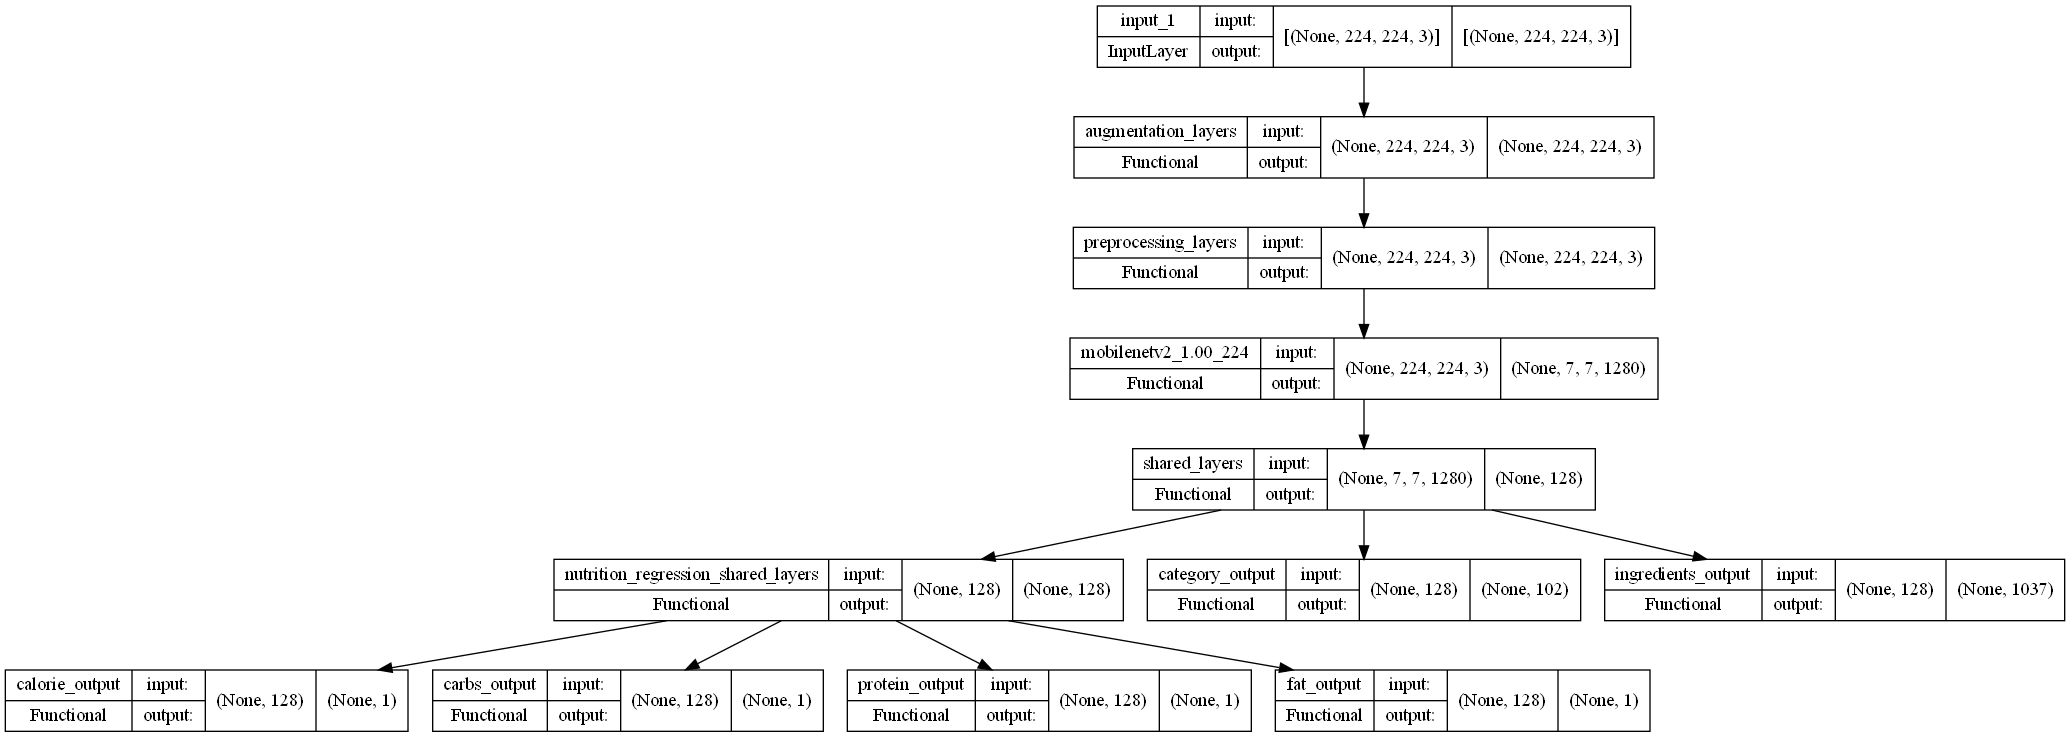

In [16]:
keras.utils.plot_model(
    flat_foodnet_mobilenetv2.model,
    "./models/flat_foodnet_mobilenetv2.png",
    show_shapes=True,
    expand_nested=False,
)

In [16]:
flat_foodnet_mobilenetv2.train_model(
    x=training_dataset, epochs=1, verbose=1, validation_data=validation_dataset
)

1211/1211 [==============================] - 2462s 2s/step - loss: 4.2934 - category_output_loss: 2.6563 - ingredients_output_loss: 0.0808 - calorie_output_loss: 0.8341 - carbs_output_loss: 0.2623 - protein_output_loss: 0.2282 - fat_output_loss: 0.2317 - category_output_categorical_accuracy: 0.3647 - category_output_precision: 0.7384 - category_output_recall: 0.1806 - ingredients_output_top_k_categorical_accuracy: 0.1168 - ingredients_output_precision_1: 0.0464 - ingredients_output_recall_1: 0.1258 - calorie_output_mean_absolute_error: 0.8340 - carbs_output_mean_absolute_error: 0.2622 - protein_output_mean_absolute_error: 0.2281 - fat_output_mean_absolute_error: 0.2316 - val_loss: 3.0614 - val_category_output_loss: 2.1192 - val_ingredients_output_loss: 0.0350 - val_calorie_output_loss: 0.7009 - val_carbs_output_loss: 0.0928 - val_protein_output_loss: 0.0327 - val_fat_output_loss: 0.0807 - val_category_output_categorical_accuracy: 0.5054 - val_category_output_precision: 0.7481 - val_cat

### ResNet50 Flat Model

In [21]:
class FlatResNet50Model(FlatModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "FlatFoodNet_with_ResNet50",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.resnet50.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        resnet50_convolution_layers = keras.applications.ResNet50(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        resnet50_convolution_layers.trainable = False
        return resnet50_convolution_layers

In [22]:
flat_foodnet_resnet50 = FlatResNet50Model(
    input_shape=(224, 224, 3),
    total_food_category=len(one_hot_encoder.all_food_categories),
    total_ingredients_category=len(one_hot_encoder.all_ingredients),
)
flat_foodnet_resnet50.build_and_compile()
flat_foodnet_resnet50.model.summary()

94781440/94765736 [==============================] - 9s 0us/step
Model: "FlatFoodNet_with_ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augmentation_layers (Functiona  (None, 224, 224, 3)  0          ['input_15[0][0]']               
 l)                                                                                               
                                                                                                  
 preprocessing_layers (Function  (None, 224, 224, 3)  0          ['augmentation_layers[0][0]']    
 al)     

In [23]:
flat_foodnet_resnet50.model.fit(
    training_dataset, epochs=1, verbose=1, validation_data=validation_dataset
)

188/188 [==============================] - 556s 3s/step - loss: 6.7551 - category_output_loss: 3.2615 - ingredients_output_loss: 0.2475 - calorie_output_loss: 1.3236 - carbs_output_loss: 0.6406 - protein_output_loss: 0.6621 - fat_output_loss: 0.6197 - category_output_categorical_accuracy: 0.3220 - category_output_precision: 0.9878 - category_output_recall: 0.2297 - ingredients_output_top_k_categorical_accuracy: 0.0808 - ingredients_output_precision_1: 0.0155 - ingredients_output_recall_1: 0.2316 - calorie_output_mean_absolute_error: 1.3227 - carbs_output_mean_absolute_error: 0.6402 - protein_output_mean_absolute_error: 0.6616 - fat_output_mean_absolute_error: 0.6190 - val_loss: 4.3995 - val_category_output_loss: 2.6068 - val_ingredients_output_loss: 0.0306 - val_calorie_output_loss: 0.8612 - val_carbs_output_loss: 0.3160 - val_protein_output_loss: 0.3141 - val_fat_output_loss: 0.2708 - val_category_output_categorical_accuracy: 0.4211 - val_category_output_precision: 0.9322 - val_catego

## Region Wise Model

In [16]:
class RegionWiseModel(BaseModel):
    def __init__(
        self, input_shape, total_food_category, total_ingredients_category, name
    ):
        super().__init__(
            input_shape, total_food_category, total_ingredients_category, name
        )
        self.augmentation_layers = self.get_augmentation_layers()
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()
        self.shared_layers = self.get_shared_layers(self.convolution_block)

        self.category_classification_layers = self.get_category_classification_layers(
            self.shared_layers, total_food_category
        )
        self.shared_nutrition_regression_layers = self.get_shared_nutrition_layers(
            self.shared_layers
        )
        self.calorie_regression_layers = self.get_calorie_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.carbs_regression_layers = self.get_carbs_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.protein_regression_layers = self.get_protein_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.fat_regression_layers = self.get_fat_regression_layers(
            self.shared_nutrition_regression_layers
        )
        self.ingredients_multilabel_layers = self.get_ingredients_multilabel_layers(
            self.convolution_block, total_ingredients_category
        )

    def get_augmentation_layers(self):
        input_layer = keras.layers.Input(shape=self.input_shape)
        augmentation_layer = keras.layers.RandomFlip()(input_layer)
        augmentation_layer = keras.layers.RandomRotation(0.2)(augmentation_layer)
        return keras.Model(
            inputs=input_layer, outputs=augmentation_layer, name="augmentation_layers"
        )

    def get_preprocess_layers(self, previous_layer):
        return None

    def get_convolution_block(self):
        return None

    def get_shared_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        shared_layer = keras.layers.Flatten()(input_layer)
        shared_layer = keras.layers.Dense(
            128, activation="relu", name="shared_dense_1"
        )(shared_layer)
        shared_layer = keras.layers.BatchNormalization()(shared_layer)
        output_layer = keras.layers.Dropout(0.2)(shared_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="shared_layers"
        )

    def get_category_classification_layers(self, previous_layer, total_categories):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        category_classification_layer = keras.layers.Dense(
            total_categories, activation="softmax", name="category_output"
        )(input_layer)
        return keras.Model(
            inputs=input_layer,
            outputs=category_classification_layer,
            name="category_output",
        )

    def get_shared_nutrition_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        nutrition_regression_layers = keras.layers.Dense(
            128, activation="relu", name="nutrition_dense_1"
        )(input_layer)
        nutrition_regression_layers = keras.layers.BatchNormalization()(
            nutrition_regression_layers
        )
        output_layer = keras.layers.Dropout(0.1)(nutrition_regression_layers)
        return keras.Model(
            inputs=input_layer,
            outputs=output_layer,
            name="nutrition_regression_shared_layers",
        )

    def get_calorie_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        calorie_regression_layers = keras.layers.Dense(1, name="calorie_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=calorie_regression_layers, name="calorie_output"
        )

    def get_carbs_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        carbs_regression_layers = keras.layers.Dense(1, name="carbs_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=carbs_regression_layers, name="carbs_output"
        )

    def get_protein_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        protein_regression_layers = keras.layers.Dense(1, name="protein_output")(
            input_layer
        )
        return keras.Model(
            inputs=input_layer, outputs=protein_regression_layers, name="protein_output"
        )

    def get_fat_regression_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        fat_regression_layers = keras.layers.Dense(1, name="fat_output")(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=fat_regression_layers, name="fat_output"
        )

    def get_ingredients_multilabel_layers(self, previous_layer, total_ingredients):
        # get the shape of the feature map (batch_size,height,width,channels)
        feature_map_shape = previous_layer.output_shape[1:]
        feature_map_height = feature_map_shape[0]
        feature_map_width = feature_map_shape[1]

        input_layer = keras.layers.Input(feature_map_shape)

        # crop the feature map into grids of feature_map_height * feature_map_width
        region_branches = []
        for row in range(1, feature_map_height + 1):
            top_crop = row - 1
            bottom_crop = feature_map_height - row
            for col in range(1, feature_map_width + 1):
                left_crop = col - 1
                right_crop = feature_map_width - col
                crop_layer = keras.layers.Cropping2D(
                    cropping=((top_crop, bottom_crop), (left_crop, right_crop))
                )(input_layer)
                flatten_layer = keras.layers.Flatten()(crop_layer)
                ingredient_prediction = keras.layers.Dense(
                    total_ingredients, activation="softmax"
                )(flatten_layer)
                reshape_layer = keras.layers.Reshape((1, total_ingredients))(
                    ingredient_prediction
                )  # reshape for global pooling 1D
                region_branches.append(reshape_layer)
        concatenate_layer = keras.layers.Concatenate(axis=1)(region_branches)
        global_max_pooling_layer = keras.layers.GlobalMaxPool1D()(concatenate_layer)
        output_layer = keras.layers.Dense(total_ingredients, activation="sigmoid")(
            global_max_pooling_layer
        )
        return keras.Model(input_layer, output_layer, name="ingredients_output")

    def build_and_compile(
        self,
        category_classification_loss=keras.losses.CategoricalCrossentropy(),
        calorie_regression_loss=keras.losses.MeanAbsoluteError(),
        carbs_regression_loss=keras.losses.MeanAbsoluteError(),
        protein_regression_loss=keras.losses.MeanAbsoluteError(),
        fat_regression_loss=keras.losses.MeanAbsoluteError(),
        ingredient_multilabel_loss=keras.losses.BinaryCrossentropy(),
        category_classification_metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        calorie_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        carbs_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        protein_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        fat_regression_metrics=[keras.metrics.MeanAbsoluteError()],
        ingredient_multilabel_metrics=[
            keras.metrics.TopKCategoricalAccuracy(5),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
        category_classification_loss_weights=1.0,
        ingredient_multilabel_loss_weights=1.0,
        calorie_regression_loss_weights=1.0,
        carbs_regression_loss_weights=1.0,
        protein_regression_loss_weights=1.0,
        fat_regression_loss_weights=1.0,
    ):
        assert (
            self.preprocess_layers != None
        ), "Error: No preprocess layers exists. Class RegionWiseModel should not be instantiated."
        assert (
            self.convolution_block != None
        ), "Error: No convolution block exists. Class RegionWiseModel should not be instantiated."
        model_inputs = self.input_layer
        x = self.augmentation_layers(model_inputs)
        x = self.preprocess_layers(x)
        x = self.convolution_block(x)
        ingredients_multilabel_head = self.ingredients_multilabel_layers(x)
        x = self.shared_layers(x)
        category_classification_head = self.category_classification_layers(x)
        nutrition_regression_head = self.shared_nutrition_regression_layers(x)
        calorie_regression_head = self.calorie_regression_layers(
            nutrition_regression_head
        )
        carbs_regression_head = self.carbs_regression_layers(nutrition_regression_head)
        protein_regression_head = self.protein_regression_layers(
            nutrition_regression_head
        )
        fat_regression_head = self.fat_regression_layers(nutrition_regression_head)

        model = keras.Model(
            inputs=model_inputs,
            outputs=[
                category_classification_head,
                ingredients_multilabel_head,
                calorie_regression_head,
                carbs_regression_head,
                protein_regression_head,
                fat_regression_head,
            ],
            name=self.name,
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss={
                "category_output": category_classification_loss,
                "calorie_output": calorie_regression_loss,
                "carbs_output": carbs_regression_loss,
                "protein_output": protein_regression_loss,
                "fat_output": fat_regression_loss,
                "ingredients_output": ingredient_multilabel_loss,
            },
            metrics={
                "category_output": category_classification_metrics,
                "calorie_output": calorie_regression_metrics,
                "carbs_output": carbs_regression_metrics,
                "protein_output": protein_regression_metrics,
                "fat_output": fat_regression_metrics,
                "ingredients_output": ingredient_multilabel_metrics,
            },
            loss_weights={
                "category_output": category_classification_loss_weights,
                "calorie_output": calorie_regression_loss_weights,
                "carbs_output": carbs_regression_loss_weights,
                "protein_output": protein_regression_loss_weights,
                "fat_output": fat_regression_loss_weights,
                "ingredients_output": ingredient_multilabel_loss_weights,
            },
        )
        self.model = model
        return model

In [17]:
class RegionWiseMobileNetv2Model(RegionWiseModel):
    def __init__(self, input_shape, total_food_category, total_ingredients_category):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "RegionWiseFoodNet_with_MobileNetv2",
        )
        self.preprocess_layers = self.get_preprocess_layers(self.augmentation_layers)
        self.convolution_block = self.get_convolution_block()

    def get_preprocess_layers(self, previous_layer):
        input_layer = keras.layers.Input(shape=previous_layer.output_shape[1:])
        output_layer = keras.applications.mobilenet_v2.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        mobilenet_v2_convolution_layers = keras.applications.MobileNetV2(
            input_shape=self.input_shape, include_top=False, weights="imagenet"
        )
        mobilenet_v2_convolution_layers.trainable = False
        return mobilenet_v2_convolution_layers

In [18]:
regionwise_foodnet_mobilenetv2 = RegionWiseMobileNetv2Model(
    (224, 224, 3),
    len(one_hot_encoder.all_food_categories),
    len(one_hot_encoder.all_ingredients),
)
regionwise_foodnet_mobilenetv2.build_and_compile()
regionwise_foodnet_mobilenetv2.model.summary()

Model: "RegionWiseFoodNet_with_MobileNetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augmentation_layers (Functiona  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 preprocessing_layers (Function  (None, 224, 224, 3)  0          ['augmentation_layers[0][0]']    
 al)                                                             

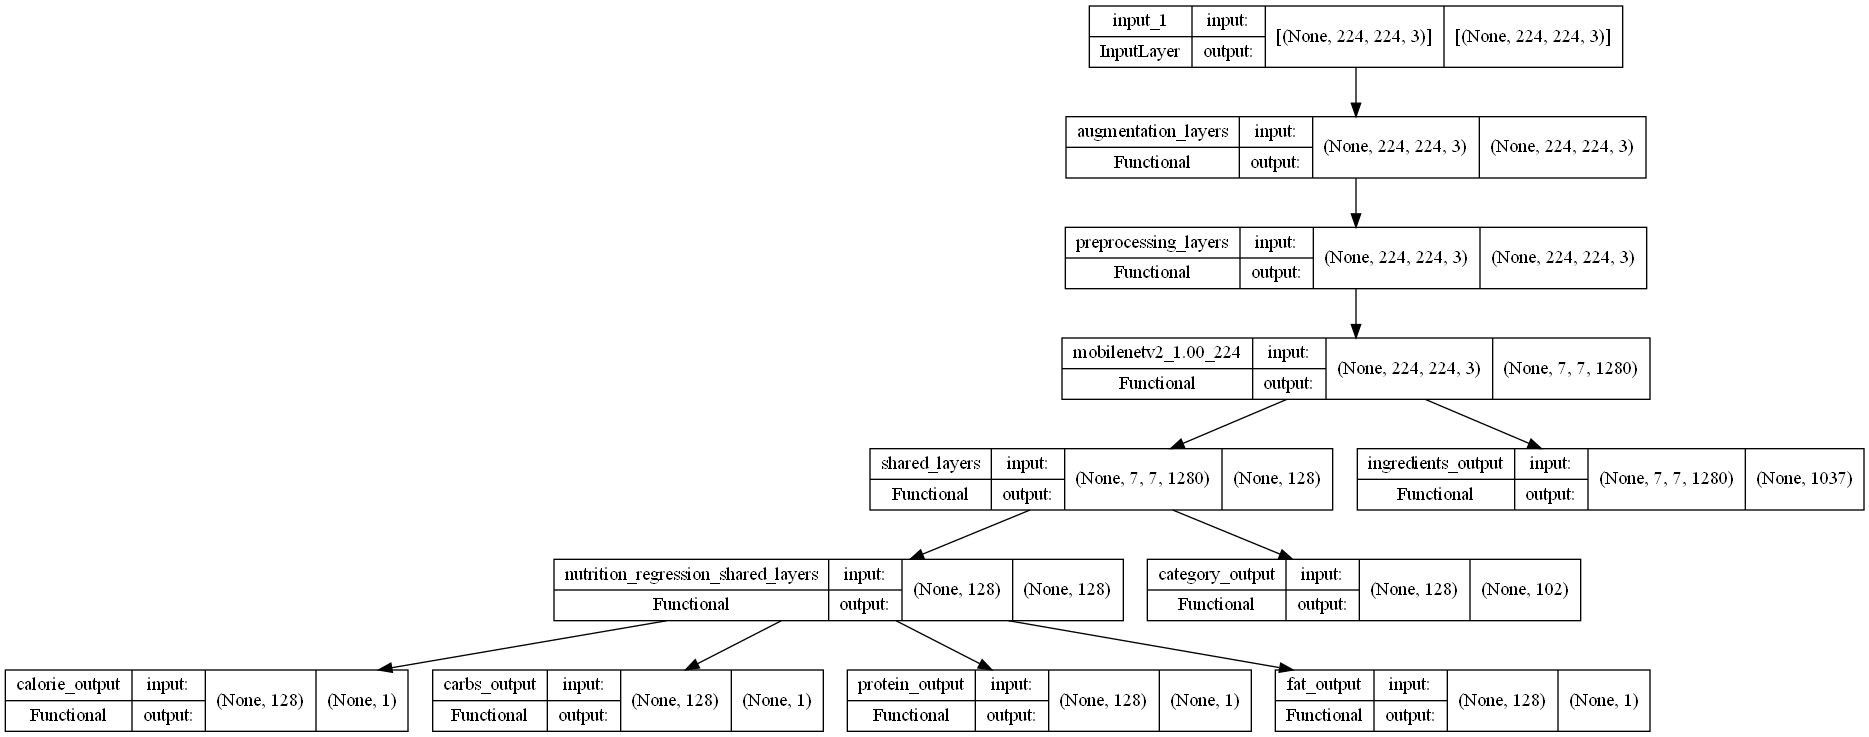

In [20]:
keras.utils.plot_model(
    regionwise_foodnet_mobilenetv2.model,
    "./models/regionwise_foodnet_mobilenetv2.png",
    show_shapes=True,
    expand_nested=False,
)

In [19]:
regionwise_foodnet_mobilenetv2.model.fit(
    training_dataset, epochs=1, verbose=1, validation_data=validation_dataset
)

188/188 [==============================] - 736s 4s/step - loss: 8.6775 - category_output_loss: 3.6148 - ingredients_output_loss: 0.5361 - calorie_output_loss: 1.9655 - carbs_output_loss: 0.9200 - protein_output_loss: 0.8524 - fat_output_loss: 0.7887 - category_output_categorical_accuracy: 0.2848 - category_output_precision_2: 0.9913 - category_output_recall_2: 0.1718 - ingredients_output_top_k_categorical_accuracy: 0.0073 - ingredients_output_precision_3: 0.0064 - ingredients_output_recall_3: 0.0402 - calorie_output_mean_absolute_error: 1.9647 - carbs_output_mean_absolute_error: 0.9195 - protein_output_mean_absolute_error: 0.8517 - fat_output_mean_absolute_error: 0.7885 - val_loss: 6.1963 - val_category_output_loss: 2.9915 - val_ingredients_output_loss: 0.3271 - val_calorie_output_loss: 1.0812 - val_carbs_output_loss: 0.6407 - val_protein_output_loss: 0.5836 - val_fat_output_loss: 0.5722 - val_category_output_categorical_accuracy: 0.3705 - val_category_output_precision_2: 0.9622 - val_

## Testing 

In [ ]:
def load_recipe5k_metadata():
    directory = (
        Path("../Food Datasets/final-dataset") / "metadata" / "recipes5k_metadata.csv"
    )
    return pd.read_csv(directory, sep="\t")

In [ ]:
data = load_recipe5k_metadata()

In [ ]:
data.head()

In [ ]:
test_recipes5k = Recipes5k()

In [ ]:
len(test_recipes5k)

In [ ]:
test_gen_func = test_recipes5k.generate_dataset()

In [ ]:
test_dataset = test_recipes5k.get_dataset()

In [ ]:
list(recipes5k.take(1))

In [ ]:
test_model = Model()

In [ ]:
test_model = test_model.build_and_compile()

In [ ]:
test_model.summary()

In [ ]:
test_model.fit(
    x=test_recipes5k.training_dataset,
    epochs=1,
    verbose=1,
    validation_data=test_recipes5k.validation_dataset,
)

In [ ]:
test = tf.constant([[[1, 2, 3]]])

In [ ]:
test.shape

In [ ]:
tf.expand_dims(test, axis=0)

In [ ]:
test_recipes5k.training_dataset

In [ ]:
test_recipes5k.validation_dataset

In [ ]:
row = 0
for x in test_recipes5k.training_dataset:
    row += 1
print(row)

In [9]:
# check training dataset (first 70%)
training_rows = int(len(recipes5k) * 0.7)
training_data = recipes5k.metadata.iloc[:training_rows]
validation_data = recipes5k.metadata.iloc[training_rows:,]

In [20]:
from pprint import pprint

In [14]:
# check categories of training
category_count = {x: 0 for x in recipes5k.extract_all_categories()}
for x in training_data["Category"].tolist():
    category_count[x] += 1

In [22]:
pprint(category_count)

{'apple_pie': 32,
 'baby_back_ribs': 31,
 'baklava': 32,
 'beef_carpaccio': 26,
 'beef_tacos': 28,
 'beef_tartare': 27,
 'beet_salad': 39,
 'beignets': 33,
 'bibimbap': 33,
 'bread_pudding': 39,
 'breakfast_burrito': 36,
 'bruschetta': 34,
 'caesar_salad': 32,
 'cannoli': 28,
 'caprese_salad': 37,
 'carrot_cake': 31,
 'ceviche': 38,
 'cheese_plate': 33,
 'cheesecake': 37,
 'chicken_curry': 33,
 'chicken_quesadilla': 34,
 'chicken_wings': 35,
 'chocolate_cake': 40,
 'chocolate_ice_cream': 36,
 'chocolate_mousse': 34,
 'churros': 34,
 'clam_chowder': 31,
 'club_sandwich': 34,
 'crab_cakes': 32,
 'creme_brulee': 35,
 'croque_madame': 30,
 'cupcakes': 31,
 'deviled_eggs': 36,
 'donuts': 37,
 'dumplings': 30,
 'edamame': 40,
 'eggs_benedict': 41,
 'escargots': 20,
 'falafel': 34,
 'filet_mignon': 38,
 'fish_and_chips': 30,
 'foie_gras': 38,
 'french_fries': 38,
 'french_onion_soup': 36,
 'french_toast': 30,
 'fried_calamari': 24,
 'fried_rice': 30,
 'frozen_yogurt': 26,
 'garlic_bread': 37,

In [17]:
validation_count = {x: 0 for x in recipes5k.extract_all_categories()}
for x in validation_data["Category"].tolist():
    validation_count[x] += 1

In [21]:
pprint(validation_count)

{'apple_pie': 17,
 'baby_back_ribs': 17,
 'baklava': 18,
 'beef_carpaccio': 3,
 'beef_tacos': 21,
 'beef_tartare': 16,
 'beet_salad': 11,
 'beignets': 16,
 'bibimbap': 17,
 'bread_pudding': 10,
 'breakfast_burrito': 13,
 'bruschetta': 16,
 'caesar_salad': 18,
 'cannoli': 19,
 'caprese_salad': 13,
 'carrot_cake': 19,
 'ceviche': 11,
 'cheese_plate': 16,
 'cheesecake': 13,
 'chicken_curry': 17,
 'chicken_quesadilla': 16,
 'chicken_wings': 13,
 'chocolate_cake': 10,
 'chocolate_ice_cream': 14,
 'chocolate_mousse': 16,
 'churros': 15,
 'clam_chowder': 19,
 'club_sandwich': 16,
 'crab_cakes': 18,
 'creme_brulee': 15,
 'croque_madame': 19,
 'cupcakes': 19,
 'deviled_eggs': 13,
 'donuts': 11,
 'dumplings': 19,
 'edamame': 9,
 'eggs_benedict': 8,
 'escargots': 6,
 'falafel': 16,
 'filet_mignon': 11,
 'fish_and_chips': 20,
 'foie_gras': 12,
 'french_fries': 11,
 'french_onion_soup': 14,
 'french_toast': 20,
 'fried_calamari': 10,
 'fried_rice': 18,
 'frozen_yogurt': 22,
 'garlic_bread': 13,
 'g

In [6]:
list(recipes5k.training_dataset.take(1))

[(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
  array([[[[235.76787 , 248.76787 , 254.92538 ],
           [237.88966 , 250.88966 , 255.      ],
           [232.3935  , 245.3935  , 253.3935  ],
           ...,
           [229.44635 , 241.      , 249.48212 ],
           [231.08926 , 241.08926 , 250.08926 ],
           [232.      , 242.      , 251.      ]],
  
          [[231.51468 , 244.51468 , 252.51468 ],
           [234.68687 , 247.68687 , 254.87372 ],
           [230.91263 , 243.91263 , 251.91263 ],
           ...,
           [229.44635 , 241.      , 249.48212 ],
           [231.0797  , 241.0797  , 250.0797  ],
           [231.96747 , 241.96747 , 250.96747 ]],
  
          [[228.08992 , 241.08992 , 249.08992 ],
           [232.98405 , 245.98405 , 253.98405 ],
           [230.66072 , 243.66072 , 251.66072 ],
           ...,
           [229.36026 , 240.91391 , 249.5746  ],
           [231.      , 241.      , 250.17857 ],
           [231.57205 , 241.57205 , 250.75063 ]],


In [8]:
mobilenet_v2_convolution_layers = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)

In [18]:
mobilenet_v2_convolution_layers.layers[-1].output_shape[1:3]

(7, 7)

In [9]:
mobilenet_v2_convolution_layers.output_shape

(None, 7, 7, 1280)

In [214]:
test_model = RegionWise_FoodNet_MobileNetv2()

In [100]:
final_model = test_model.mobilenetv2_convolution_block(test_model.input_layer)

In [101]:
final_model = test_model.ingredient_classifier(final_model)

In [104]:
t = keras.Model(test_model.input_layer, final_model)

In [105]:
t.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 ingredients_classifier (Fun  (None, 892)              55991732  
 ctional)                                                        
                                                                 
Total params: 58,249,716
Trainable params: 55,991,732
Non-trainable params: 2,257,984
_________________________________________________________________


In [215]:
test_model.ingredient_classifier.summary()

Model: "ingredients_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 7, 7, 1280)  0           []                               
                                ]                                                                 
                                                                                                  
 cropping2d_839 (Cropping2D)    (None, 1, 1, 1280)   0           ['input_73[0][0]']               
                                                                                                  
 cropping2d_840 (Cropping2D)    (None, 1, 1, 1280)   0           ['input_73[0][0]']               
                                                                                                  
 cropping2d_841 (Cropping2D)    (None, 1, 1, 1280)   0           ['input_73[0

In [205]:
import numpy as np

x = keras.layers.concatenate(
    [
        tf.constant([1, 0, 1]),
        tf.constant([0, 0, 2]),
        tf.constant([1, 0, 1]),
        tf.constant([5, 0, 1]),
    ],
    axis=0,
)

In [206]:
s = tf.reshape(x, (1, 4, 3))

In [209]:
keras.layers.MaxPooling1D()(s)

<tf.Tensor: shape=(1, 2, 3), dtype=int32, numpy=
array([[[1, 0, 2],
        [5, 0, 1]]])>

In [207]:
keras.layers.GlobalMaxPooling1D()(s)

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[5, 0, 2]])>

In [5]:
df = tf.data.Dataset.range(300000)
df = df.shuffle(200000)
list(df.take(1))

[<tf.Tensor: shape=(), dtype=int64, numpy=26913>]

In [16]:
#     # Overriding the method from DatasetLoader
#     def generate_dataset(self):
#         img_dir = self.dir_path / "images"
#         for index, row in self.metadata.iterrows():
#             dish_dir = img_dir / row["Category"] / row["dish_id"]
#             for img_path in dish_dir.iterdir():
#                 assert (
#                     img_path.suffix == ".jpeg" or img_path.suffix == ".png"
#                 ), f"{img_path} is not an expected image file"
#                 img_tensor = self.load_image_to_arr(img_path)
#                 calorie_tensor = row["Calorie(kcal)"]
#                 carbs_tensor = row["Carbohydrate(g)"]
#                 protein_tensor = row["Protein(g)"]
#                 fat_tensor = row["Fat(g)"]
#                 one_hot_category_tensor = (
#                     self.one_hot_encoder.get_category_one_hot_encoding(row["Category"])
#                 )
#                 one_hot_ingredient_tensor = (
#                     self.one_hot_encoder.get_ingredients_one_hot_encoding(
#                         row["Ingredients"].split(",")
#                     )
#                 )
#                 yield tf.constant(img_tensor), {
#                     "category_output": tf.constant(one_hot_category_tensor),
#                     "calorie_output": tf.constant(calorie_tensor),
#                     "carbs_output": tf.constant(carbs_tensor),
#                     "protein_output": tf.constant(protein_tensor),
#                     "fat_output": tf.constant(fat_tensor),
#                     "ingredients_output": one_hot_ingredient_tensor,
#                 }

#     # Overriding the method from DatasetLoader
#     def get_dataset(self):
#         dataset = tf.data.Dataset.from_generator(
#             self.generate_dataset,
#             output_signature=(
#                 tf.TensorSpec(shape=(224, 224, 3), dtype=tf.dtypes.float32),
#                 {
#                     "category_output": tf.TensorSpec(
#                         shape=(len(self.one_hot_encoder.all_food_categories)),
#                         dtype=tf.dtypes.float32,
#                     ),
#                     "calorie_output": tf.TensorSpec(shape=(), dtype=tf.dtypes.float32),
#                     "carbs_output": tf.TensorSpec(shape=(), dtype=tf.dtypes.float32),
#                     "protein_output": tf.TensorSpec(shape=(), dtype=tf.dtypes.float32),
#                     "fat_output": tf.TensorSpec(shape=(), dtype=tf.dtypes.float32),
#                     "ingredients_output": tf.TensorSpec(
#                         shape=(len(self.one_hot_encoder.all_ingredients)),
#                         dtype=tf.dtypes.float32,
#                     ),
#                 },
#             ),
#         )
#         return dataset.shuffle(len(self.metadata) * 30, seed=1234)

In [38]:
tf.constant("sting")

<tf.Tensor: shape=(), dtype=string, numpy=b'sting'>